In [1]:
import pandas as pd

columns_cust = [
    'c_custkey', 'c_name', 'c_address', 'c_nationkey',
    'c_phone', 'c_acctbal', 'c_mktsegment', 'c_comment'
]
columns_supplier = ['s_suppkey', 's_name', 's_address', 's_nationkey', 's_phone', 's_acctbal', 's_comment']

columns_lineitem = ['l_orderkey', 'l_partkey', 'l_suppkey', 'l_linenumber', 'l_quantity',
            'l_extendedprice', 'l_discount', 'l_tax', 'l_returnflag', 'l_linestatus',
            'l_shipdate', 'l_commitdate', 'l_receiptdate', 'l_shipinstruct', 'l_shipmode', 'l_comment']

columns_nation = ['n_nationkey', 'n_name', 'n_regionkey', 'n_comment']

columns_region = ['r_regionkey', 'r_name', 'r_comment']

columns_orders = ['o_orderkey', 'o_custkey', 'o_orderstatus', 'o_totalprice', 'o_orderdate',
          'o_orderpriority', 'o_clerk', 'o_shippriority', 'o_comment']

df_customer = pd.read_csv(
    '/content/customer.csv',
    sep='|',
    header=None,
    names=columns_cust,
    index_col=False,
    dtype={'c_phone': str}
)

df_lineitem = pd.read_csv(
    '/content/lineitem.csv',
    sep='|',
    header=None,
    names=columns_lineitem,
    index_col=False,
    dtype={'c_phone': str}
)
df_supplier = pd.read_csv(
    '/content/supplier.csv',
    sep='|',
    header=None,
    names=columns_supplier,
    index_col=False,
    dtype={'c_phone': str}
)
df_nation = pd.read_csv(
    '/content/nation.csv',
    sep='|',
    header=None,
    names=columns_nation,
    index_col=False,
    dtype={'c_phone': str}
)
df_region = pd.read_csv(
    '/content/region.csv',
    sep='|',
    header=None,
    names=columns_region,
    index_col=False,
    dtype={'c_phone': str}
)
df_orders = pd.read_csv(
    '/content/orders.csv',
    sep='|',
    header=None,
    names=columns_orders,
    index_col=False,
    dtype={'c_phone': str}
)

df_customer = df_customer.dropna(axis=1, how='all')
df_lineitem = df_lineitem.dropna(axis=1, how='all')
df_supplier = df_supplier.dropna(axis=1, how='all')
df_nation = df_nation.dropna(axis=1, how='all')
df_region = df_region.dropna(axis=1, how='all')
df_orders = df_orders.dropna(axis=1, how='all')


In [103]:
df_customer.shape

(15000, 8)

In [ ]:
'''

SELECT
  c_custkey,
  s_suppkey,
  SUM(l_extendedprice * (1 - l_discount)) AS revenue
FROM
  customer,
  orders,
  lineitem,
  supplier,
  nation,
  region
WHERE
  c_custkey = o_custkey
  AND l_orderkey = o_orderkey
  AND l_suppkey = s_suppkey
  AND c_nationkey = s_nationkey
  AND s_nationkey = n_nationkey
  AND n_regionkey = r_regionkey
  AND r_name = '[REGION]'
  AND o_orderdate >= DATE '[DATE]'
  AND o_orderdate < DATE '[DATE]' + INTERVAL '1' YEAR
GROUP BY
  c_custkey,
  s_suppkey
ORDER BY
  revenue DESC;

'''

In [2]:
def calculate_revenue_pandas(df_customer, df_orders, df_lineitem, df_supplier, df_nation, df_region, region_name, start_date):
    # 合并所有表（模拟 SQL JOIN）
    merged = (
        df_customer.merge(df_orders, left_on='c_custkey', right_on='o_custkey')
        .merge(df_lineitem, left_on='o_orderkey', right_on='l_orderkey')
        .merge(df_supplier, left_on='l_suppkey', right_on='s_suppkey')
        .merge(df_nation, left_on='c_nationkey', right_on='n_nationkey')
        .merge(df_region, left_on='n_regionkey', right_on='r_regionkey')
    )

    filtered = merged[
        (merged['r_name'] == region_name) &
        (merged['o_orderdate'] >= start_date) &
        (pd.to_datetime(merged['o_orderdate']) < (pd.to_datetime(start_date) + pd.DateOffset(years=1)))
    ]

    filtered['revenue'] = filtered['l_extendedprice'] * (1 - filtered['l_discount'])
    filtered.reset_index(drop=True, inplace=True)

    return filtered

In [3]:
region_name = 'ASIA'
start_date = '1994-01-01'
result = calculate_revenue_pandas(df_customer, df_orders, df_lineitem, df_supplier, df_nation, df_region, region_name, start_date)

/tmp/ipython-input-2-2415360908.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['revenue'] = filtered['l_extendedprice'] * (1 - filtered['l_discount'])


In [4]:
result.shape

(18948, 48)

In [17]:
from scipy.optimize import linprog
from scipy.sparse import lil_matrix,vstack
import numpy as np

def create_matrix(result,tau):
        result['u_var'] = [f'u{i+1}' for i in range(result.shape[0])]
        num_vars = result.shape[0]
        A_single = lil_matrix((num_vars, num_vars))
        b_single = result['revenue'].values

        for i in range(num_vars):
            A_single[i, i] = 1

        grouped_1 = result.groupby('c_custkey').groups
        grouped_2 = result.groupby('s_suppkey').groups

        A_group_1 = lil_matrix((len(grouped_1), num_vars))
        b_group_1 = np.full(len(grouped_1), tau)

        A_group_2 = lil_matrix((len(grouped_2), num_vars))
        b_group_2 = np.full(len(grouped_2), tau)

        for group_idx, (name, rows) in enumerate(grouped_1.items()):
            for row in rows:
                A_group_1[group_idx, row] = 1

        for group_idx, (name, rows) in enumerate(grouped_2.items()):
            for row in rows:
                A_group_2[group_idx, row] = 1

        A_ub = vstack([A_single, A_group_1, A_group_2]).tocsr()
        b_ub = np.concatenate([b_single, b_group_1, b_group_2])

        return num_vars,A_ub,b_ub

In [5]:
import numpy as np
import math

def laplace(GS_Q, epsilon, tau):
    scale = math.log(GS_Q, 2) * tau / epsilon
    noise = np.random.laplace(loc=0, scale=scale)
    return noise

In [18]:
def solve_linear(result, iter_num, gsq, epsilon, beta):
  revenue_sum = []
  q_hat = []
  tau = []
  j=0
  for i in range(iter_num):
      tau.append(2 ** i)
      num_vars,A_ub,b_ub = create_matrix(result,2 ** i)
      c = -np.ones(num_vars)

      result_func = linprog(
          c, A_ub=A_ub, b_ub=b_ub,
          method='highs'

      )
      non_zero_indices = np.where(result_func.x > 1e-6)[0]
      revenue_sum.append(result.loc[non_zero_indices, 'revenue'].sum())
      noise = laplace(gsq, epsilon, 2 ** i)
      term = math.log(gsq, 2) * math.log(math.log(gsq, 2)/beta,math.e) * ((2 ** i) / epsilon)
      q_hat.append(result.loc[non_zero_indices, 'revenue'].sum() + noise - term)

      j+=1

  return np.array(revenue_sum), np.array(q_hat), np.array(tau)


In [19]:
revenue_sum, q_hat, tau = solve_linear(result, 23, 10**7, 1, 0.1)

In [44]:
epsilon = [0.5, 1.0, 1.5, 2.0]
#epsilon = [0.5]
beta = [0.05, 0.1, 0.15, 0.2]
revenue_sum_total, q_hat_total, tau_total = [],[],[]
for e in epsilon:
  for b in beta:
    revenue_sum, q_hat, tau = solve_linear(result, 22, 10**6, e, b)
    revenue_sum_total.append(revenue_sum)
    q_hat_total.append(q_hat)
    tau_total.append(tau)

In [46]:
difference = []
for t in range(10):
  revenue_sum_total, q_hat_total, tau_total = [],[],[]
  for i in [6,7,8,9]:
      revenue_sum, q_hat, tau = solve_linear(result, 22, 10**i, 2, 0.1)
      revenue_sum_total.append(revenue_sum)
      q_hat_total.append(q_hat)
      tau_total.append(tau)
      max_idx = np.argmax(q_hat)
      max_tau = tau[max_idx]
      max_q_hat = q_hat[max_idx]
      revenue_at_max = revenue_sum[max_idx]
      difference.append(float(revenue_at_max - max_q_hat))

In [47]:
final_difference = [np.mean(difference[0::4]), np.mean(difference[1::4]), np.mean(difference[2::4]), np.mean(difference[3::4])]

In [49]:
final_difference

[np.float64(52226987.55132111),
 np.float64(72026157.35303444),
 np.float64(62980555.88401441),
 np.float64(86976680.79790752)]

In [42]:
revenue_sum_total, q_hat_total, tau_total = [],[],[]
for i in [6,7,8,9]:
      revenue_sum, q_hat, tau = solve_linear(result, 22, 10**i, 2, 0.2)
      revenue_sum_total.append(revenue_sum)
      q_hat_total.append(q_hat)
      tau_total.append(tau)

In [ ]:
revenue_sum, q_hat, tau = solve_linear(result, 22, 10**i, 2, 0.2)

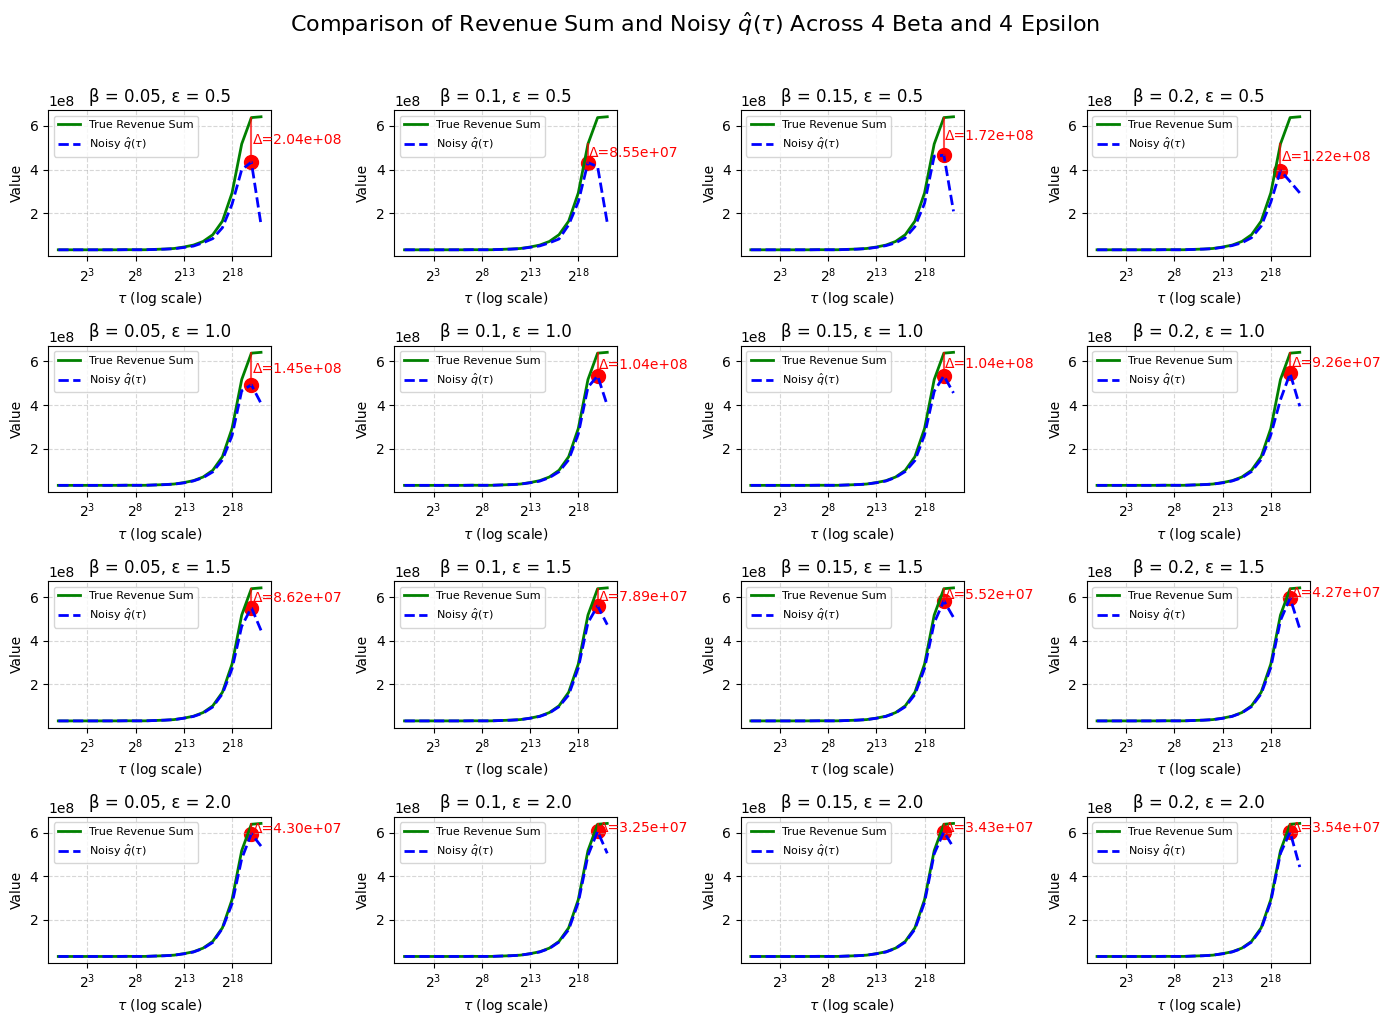

In [45]:
import matplotlib.pyplot as plt
data_groups = []
epsilon = [0.5, 0.5, 0.5, 0.5, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 2.0, 2.0, 2.0, 2.0]
beta = [0.05, 0.1, 0.15, 0.2, 0.05, 0.1, 0.15, 0.2, 0.05, 0.1, 0.15, 0.2, 0.05, 0.1, 0.15, 0.2]
for i in range(len(q_hat_total)):
    data_groups.append({
        'tau': tau_total[i],
        'revenue_sum': revenue_sum_total[i],
        'q_hat': q_hat_total[i],
        'beta' : beta[i],
        'epsilon' : epsilon[i]
    })

fig, axes = plt.subplots(4, 4, figsize=(14, 10))
fig.suptitle('Comparison of Revenue Sum and Noisy $\hat{q}(\\tau)$ Across 4 Beta and 4 Epsilon',
             fontsize=16, y=1.02)

for idx, (ax, data) in enumerate(zip(axes.flatten(), data_groups)):
    tau = np.array(data['tau'])
    revenue_sum = np.array(data['revenue_sum'])
    q_hat = np.array(data['q_hat'])
    beta = np.array(data['beta'])
    epsilon = np.array(data['epsilon'])


    ax.plot(tau, revenue_sum, 'g-', label='True Revenue Sum', linewidth=2)
    ax.plot(tau, q_hat, 'b--', label='Noisy $\hat{q}(\\tau)$', linewidth=2)

    max_idx = np.argmax(q_hat)
    max_tau = tau[max_idx]
    max_q_hat = q_hat[max_idx]
    revenue_at_max = revenue_sum[max_idx]
    difference = "{:.2e}".format(float(revenue_at_max - max_q_hat))

    ax.scatter(max_tau, max_q_hat, color='red', s=100)
    ax.plot([max_tau, max_tau], [revenue_at_max, max_q_hat],
         'r-', linewidth=1.5, alpha=0.7)
    ax.text(max_tau*1.1, (revenue_at_max + max_q_hat)/2,
         f'Δ={difference}', color='red', va='center')


    ax.set_xscale('log', base=2)
    ax.set_xlabel('$\\tau$ (log scale)', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.set_title(f'β = {beta}, ε = {epsilon}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


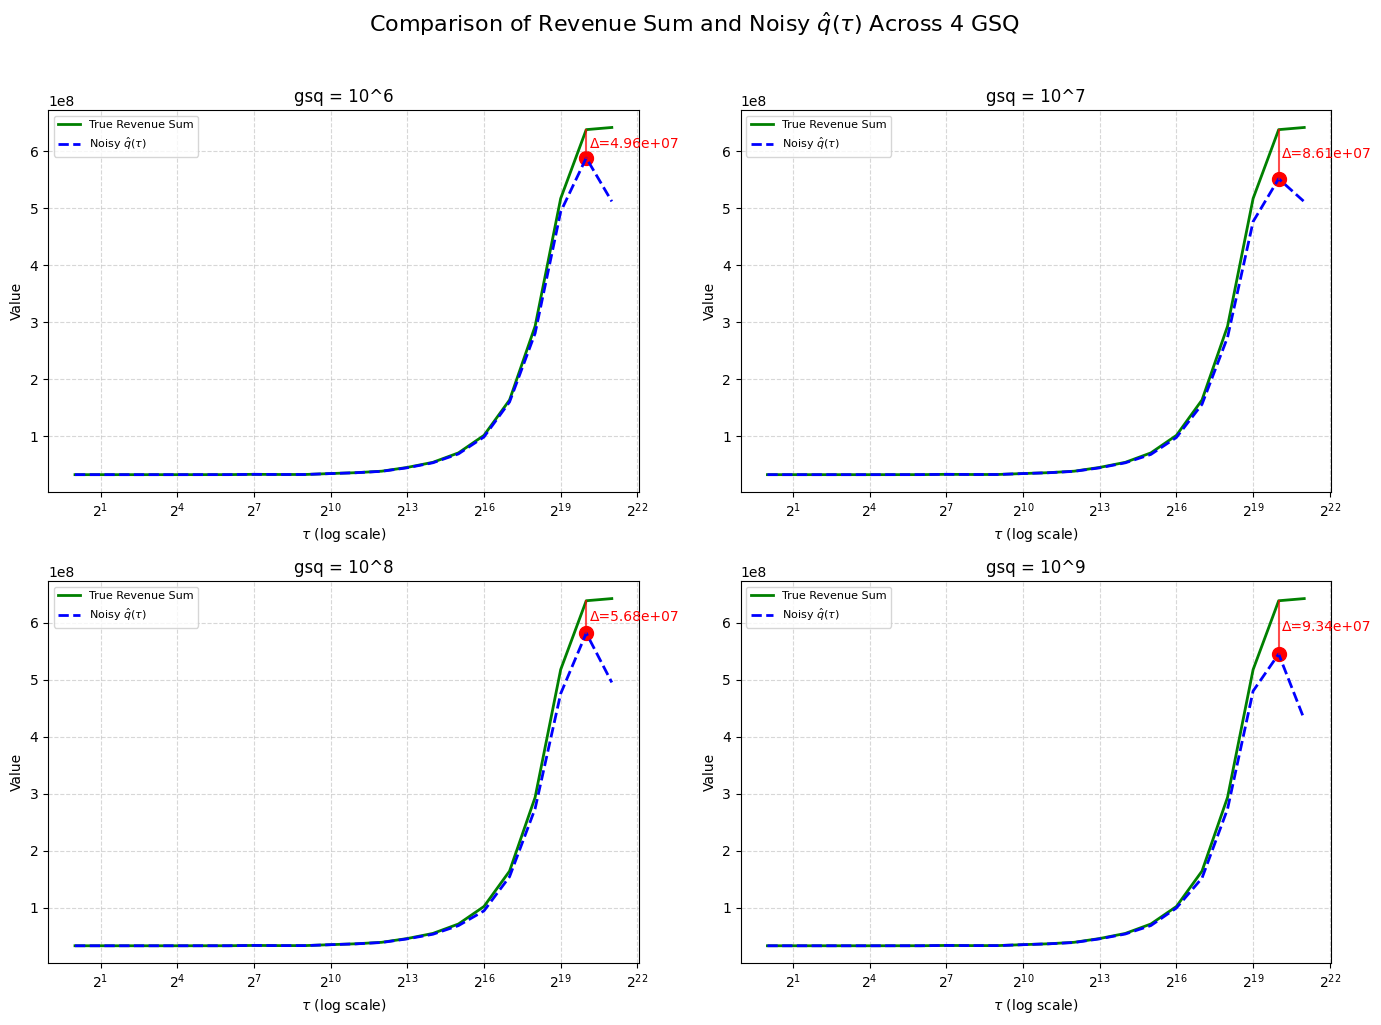

In [48]:
import matplotlib.pyplot as plt
data_groups = []
gsq = ['10^6','10^7','10^8','10^9']
for i in range(len(q_hat_total)):
    data_groups.append({
        'tau': tau_total[i],
        'revenue_sum': revenue_sum_total[i],
        'q_hat': q_hat_total[i],
        'gsq' : gsq[i]
    })

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparison of Revenue Sum and Noisy $\hat{q}(\\tau)$ Across 4 GSQ',
             fontsize=16, y=1.02)

for idx, (ax, data) in enumerate(zip(axes.flatten(), data_groups)):
    tau = np.array(data['tau'])
    revenue_sum = np.array(data['revenue_sum'])
    q_hat = np.array(data['q_hat'])
    gsq = np.array(data['gsq'])

    ax.plot(tau, revenue_sum, 'g-', label='True Revenue Sum', linewidth=2)
    ax.plot(tau, q_hat, 'b--', label='Noisy $\hat{q}(\\tau)$', linewidth=2)

    max_idx = np.argmax(q_hat)
    max_tau = tau[max_idx]
    max_q_hat = q_hat[max_idx]
    revenue_at_max = revenue_sum[max_idx]
    difference = "{:.2e}".format(float(revenue_at_max - max_q_hat))

    ax.scatter(max_tau, max_q_hat, color='red', s=100)
    ax.plot([max_tau, max_tau], [revenue_at_max, max_q_hat],
         'r-', linewidth=1.5, alpha=0.7)
    ax.text(max_tau*1.1, (revenue_at_max + max_q_hat)/2,
         f'Δ={difference}', color='red', va='center')

    ax.set_xscale('log', base=2)
    ax.set_xlabel('$\\tau$ (log scale)', fontsize=10)
    ax.set_ylabel('Value', fontsize=10)
    ax.set_title(f'gsq = {gsq}', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [109]:
q_hat_total

[array([ 1.26196963e+07,  1.24206562e+07,  1.25073829e+07,  1.30305346e+07,
         1.25938429e+07,  1.25895850e+07,  1.24636073e+07,  1.25481578e+07,
         1.23365298e+07,  1.25986826e+07,  1.25669845e+07,  1.27238824e+07,
         1.28284137e+07,  1.41118402e+07,  1.30184675e+07,  1.30907645e+07,
         1.87632487e+07,  2.63156351e+07,  3.95548645e+07, -3.68318044e+06,
         6.15695914e+07,  9.50621830e+07, -3.60774765e+08]),
 array([ 1.26197553e+07,  1.24208699e+07,  1.25083479e+07,  1.30303788e+07,
         1.25953634e+07,  1.25879634e+07,  1.24693867e+07,  1.25700790e+07,
         1.23614428e+07,  1.26607537e+07,  1.25760713e+07,  1.25725442e+07,
         1.21525021e+07,  1.39722280e+07,  1.42709536e+07,  1.53036887e+07,
         2.30523758e+07,  2.94574009e+07,  3.80148035e+07,  1.02948358e+08,
         1.16479923e+08,  6.47601855e+07, -2.91737519e+08]),
 array([ 1.26197930e+07,  1.24208989e+07,  1.25076048e+07,  1.30310422e+07,
         1.25951053e+07,  1.25904438e+07, 

In [33]:
def find_diff(revenue_sum_total, q_hat_total, tau_total):
  diff=np.zeros(len(q_hat_total))
  for i in range(len(q_hat_total)):
    for j in range(len(q_hat_total[i])):
      max_idx = np.argmax(q_hat_total[i])
      tau_at_max = tau_total[i][max_idx]
      q_hat_max = q_hat_total[i][max_idx]
      revenue_sum_at_max = revenue_sum_total[i][max_idx]
    diff[i] = revenue_sum_at_max - q_hat_max

  return diff

In [34]:
diff=find_diff(revenue_sum_total, q_hat_total, tau_total)
diff

/tmp/ipython-input-33-2911268547.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  diff[i] = revenue_sum_at_max - q_hat_max


array([1.89111237e+08, 1.96501675e+08, 2.47274600e+08, 1.11153919e+08])